<a href="https://colab.research.google.com/github/Lelan30/Open-Projects/blob/main/Housing_Prices_Predictions(CatBoost_vs_RandomForest).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***House Prices Predictions***

**Installs**

In [57]:
!pip install tensorflow_decision_forests
!pip install catboost

**Imports**

In [58]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow_decision_forests as tfdf

from catboost import CatBoostRegressor
from zipfile import ZipFile

**Configure Enviroment:**

In [59]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [60]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"","key":""}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

mkdir: cannot create directory ‘/root/.kaggle’: File exists


**Download**

In [61]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


**Unzip files:**

In [62]:
file_name="/content/house-prices-advanced-regression-techniques.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


**Load the dataset**:

In [63]:
test_df = pd.read_csv("test.csv")

test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [64]:
test_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [65]:
dataset_df = pd.read_csv("train.csv")
dataset_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [66]:
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.isnull().sum()

Full train dataset shape is (1460, 81)


Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

The dataset contains 81 columns and 1460 entries. printing out the first 3 to 5 entries we can see the 81 dimensions. We'll be using the 79 feature columns to predict the house sale prices indicated by the "SalePrice"

In [67]:
# dropping the unessesary "Id" column
dataset_df = dataset_df.drop("Id", axis=1)
dataset_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **Numerical & Housing Data Distribution**

Checking numerical data distribution:

In [68]:
# list all the types of data from the dataset and select only the numerical ones
list(set(dataset_df.dtypes.tolist()))


[dtype('float64'), dtype('O'), dtype('int64')]

In [69]:
df_num = dataset_df.select_dtypes(include=['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

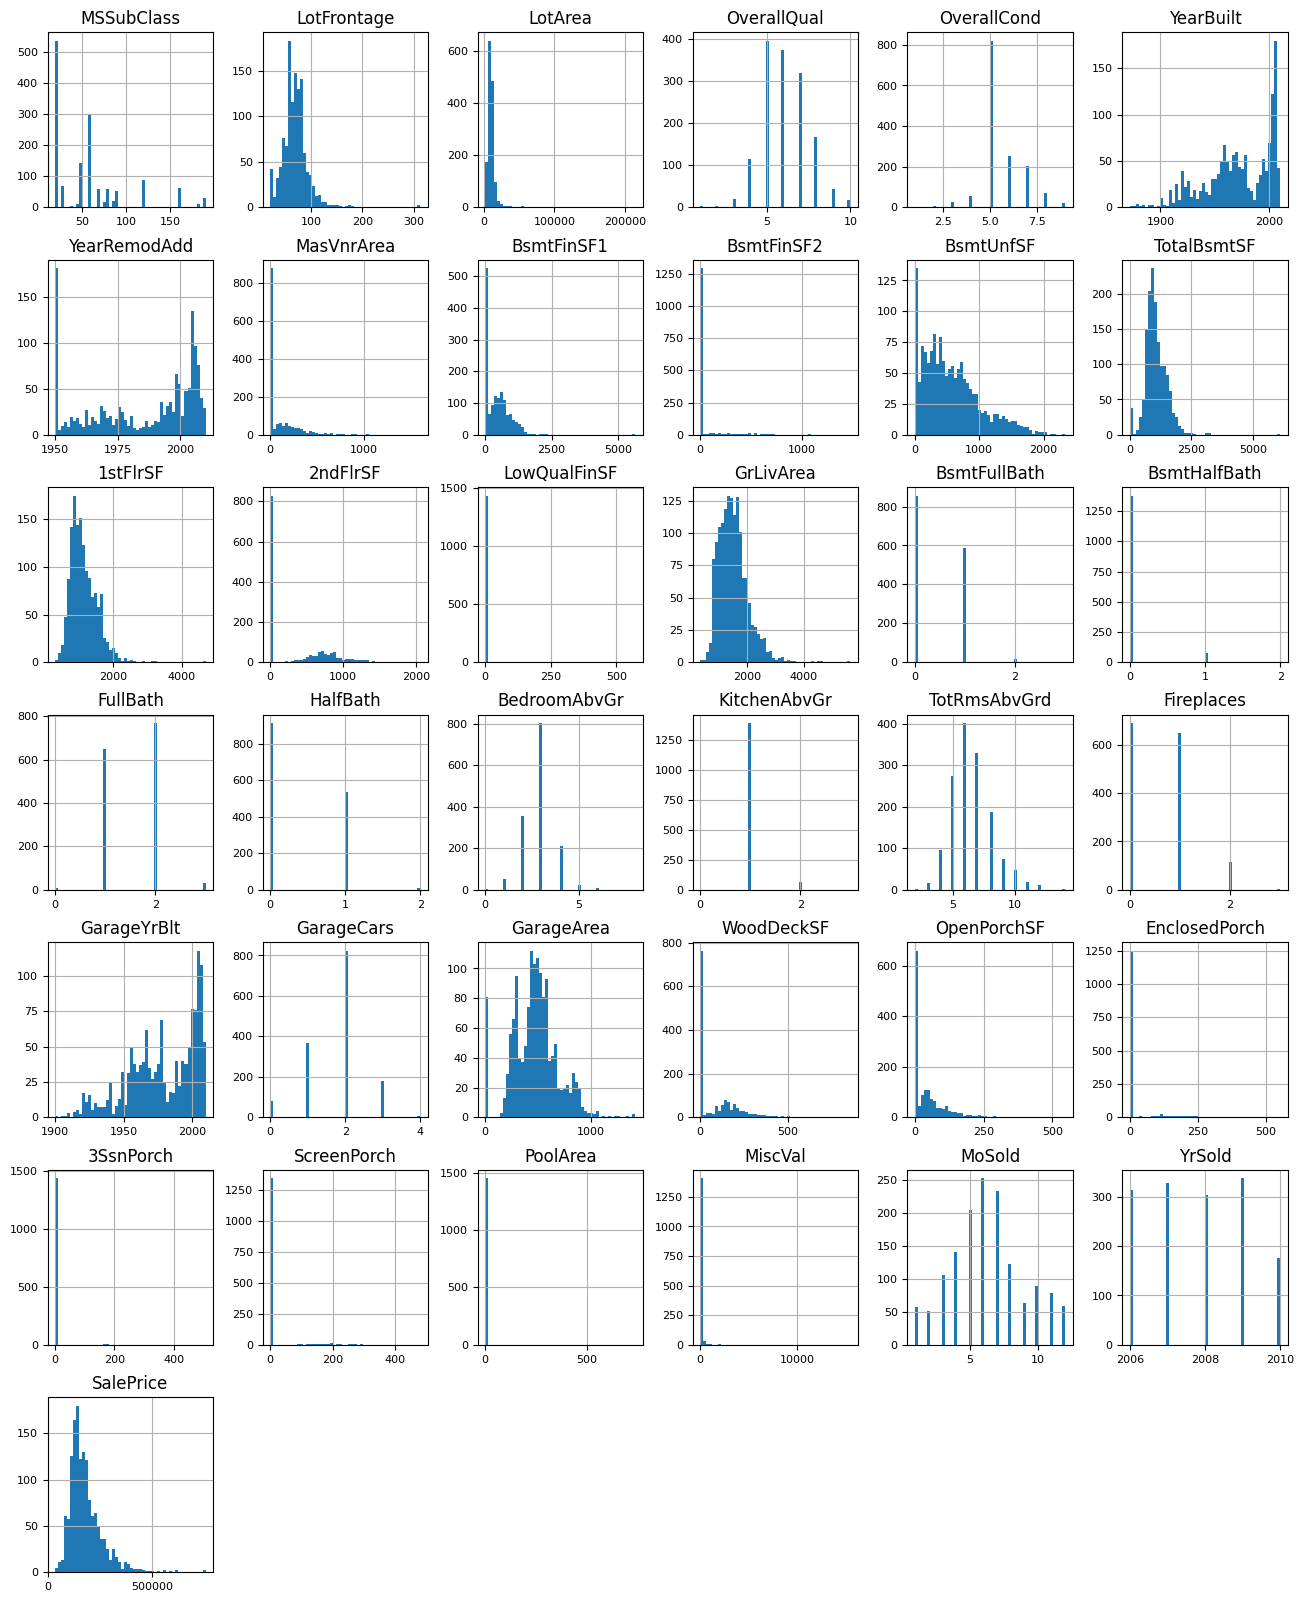

In [70]:
# plotting distribution for all numerical features
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Housing Data Distributiion

In [71]:
# getting a description of the SalePrice data
print(dataset_df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-72-88a421134765>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='b',


<Axes: xlabel='SalePrice', ylabel='Density'>

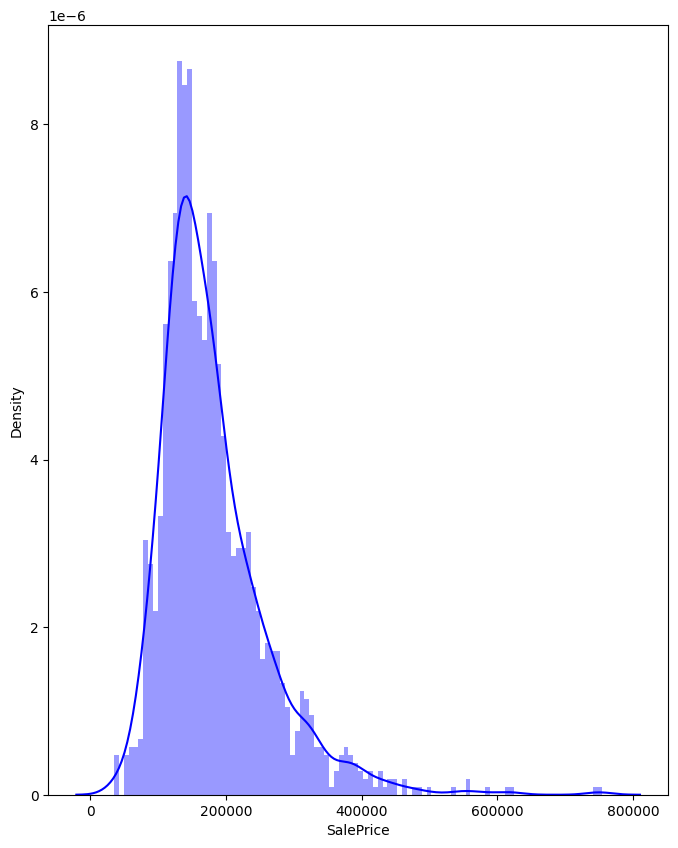

In [72]:
# plotting
plt.figure(figsize=(8,10))
sns.distplot(dataset_df['SalePrice'], color='b',
             bins=100,hist_kws={'alpha':0.4})

# **Preparing the Dataset:**

<ipython-input-73-781619cd163e>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset_df.corr(), annot=True, annot_kws={"size": 6},


<Axes: >

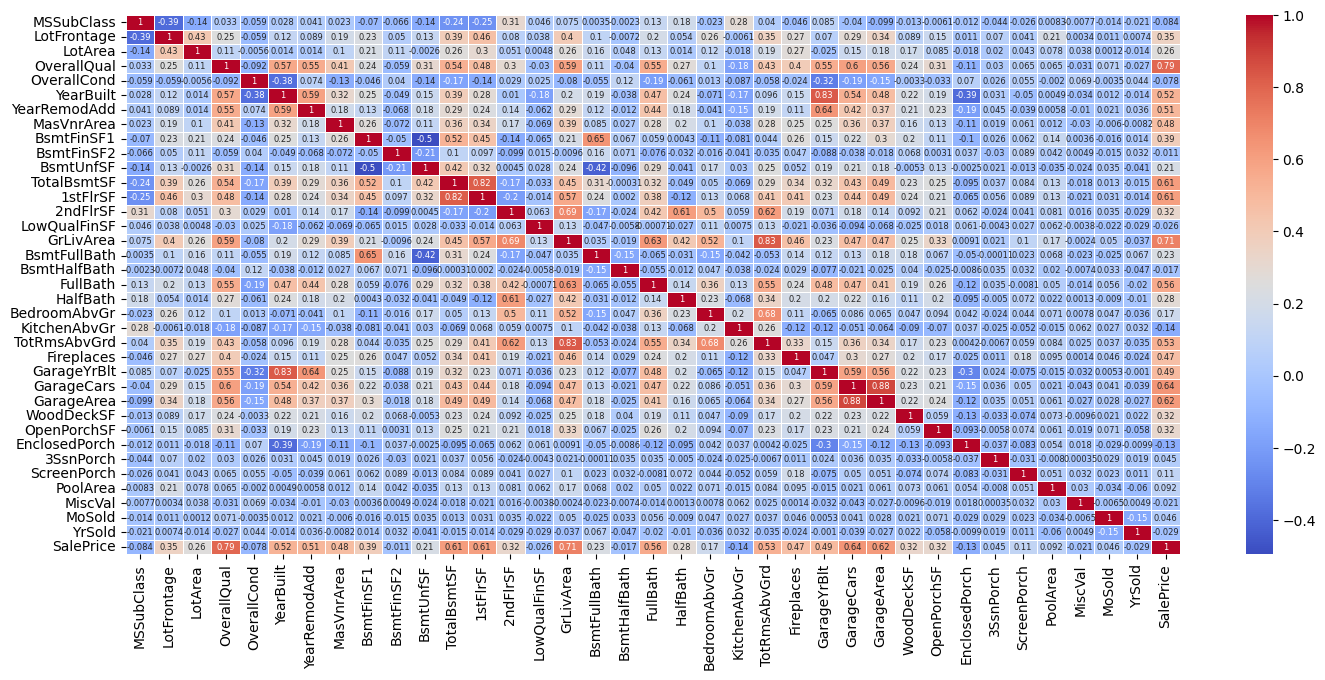

In [73]:
# Checking correlations in datasets

plt.figure(figsize=(17, 7))
sns.heatmap(dataset_df.corr(), annot=True, annot_kws={"size": 6},
            cmap='coolwarm', linewidths=.5)

<ipython-input-74-f599561f67c7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(test_df.corr(), annot=True, annot_kws={"size": 6},


<Axes: >

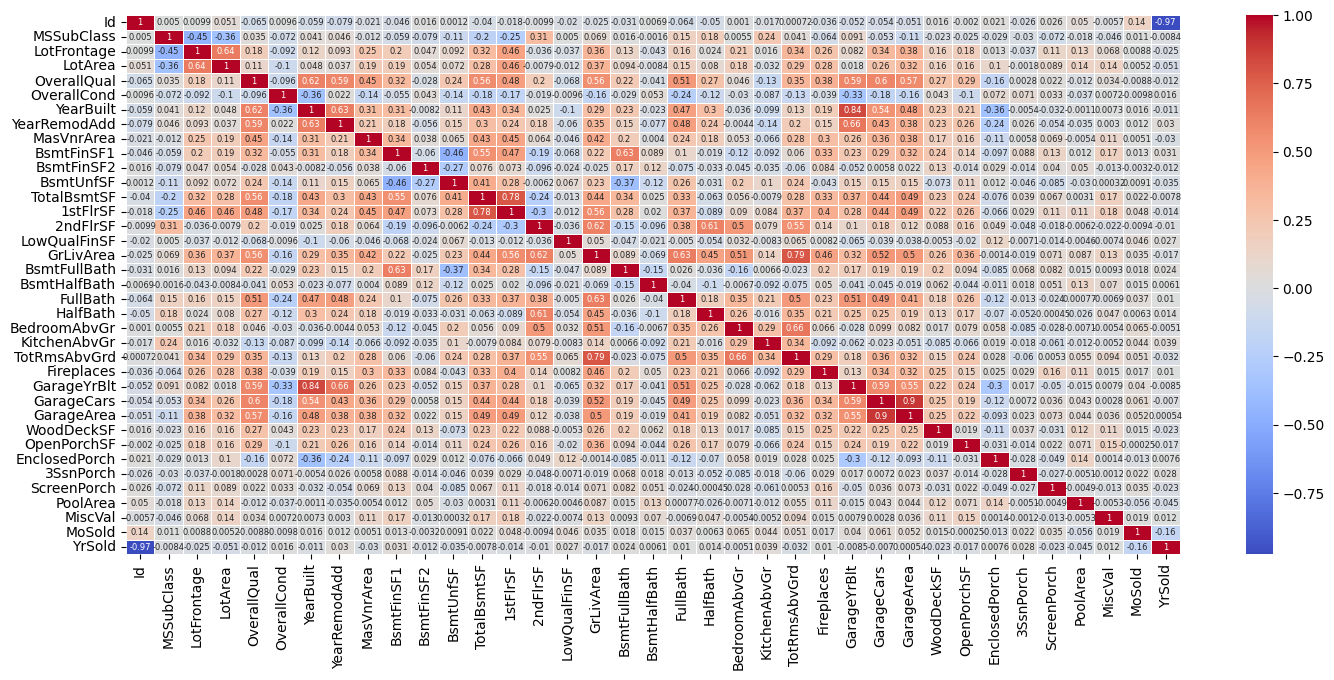

In [74]:
plt.figure(figsize=(17, 7))
sns.heatmap(test_df.corr(), annot=True, annot_kws={"size": 6},
            cmap='coolwarm', linewidths=.5)

 OverallQual, GrLivArea columns has the highest correlation with the SalePrice column.

***Remove Outliers***

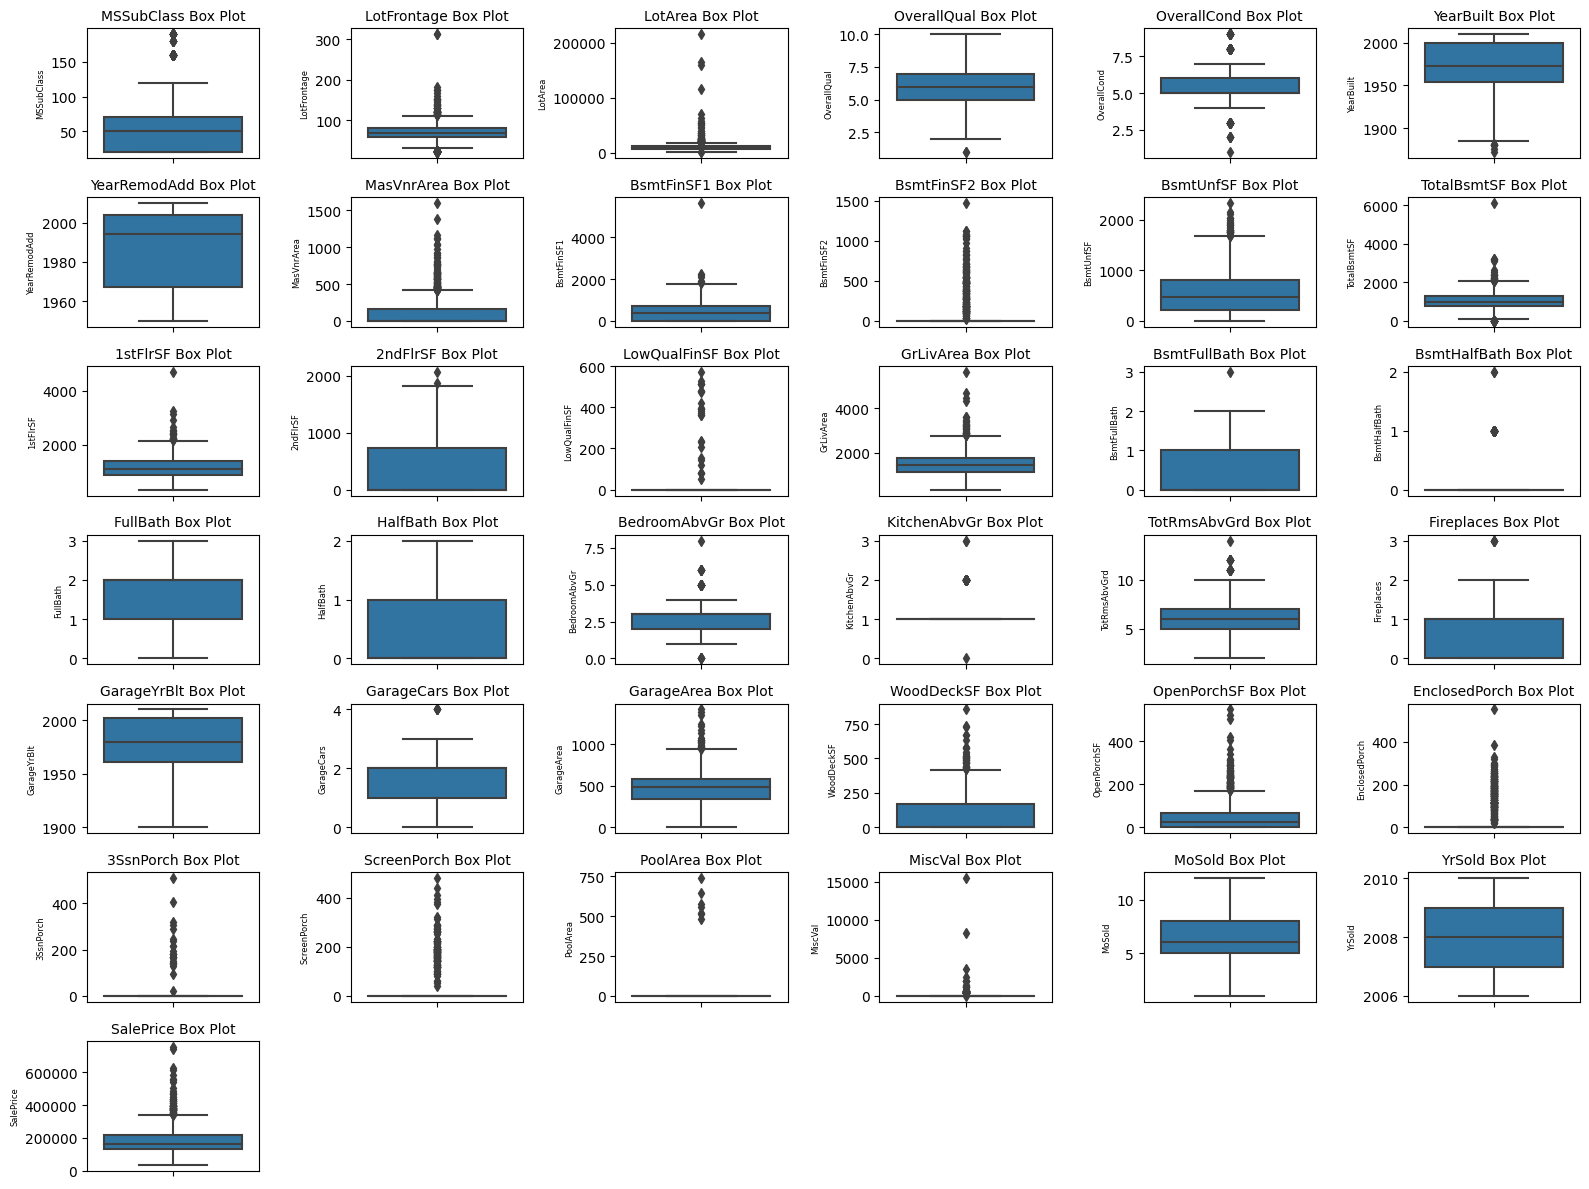

In [75]:
num_cols = df_num.shape[1]
num_rows = math.ceil(num_cols / 6)
fig, axes = plt.subplots(num_rows, 6, figsize=(16, 12))

# Flatten
axes = axes.ravel()

# Looping through numeric columns, creating box plots for visualization on outliers
for i, column in enumerate(df_num.columns):
  sns.boxplot(data=df_num,y=column,ax=axes[i])
  axes[i].set_title(f'{column} Box Plot', fontsize=10)
  axes[i].set_ylabel(column, fontsize=6)
  axes[i].tick_params(axis='both',which='both',labelsize=10)

# Remove empty subplots
for i in range(num_cols, num_rows * 6):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [76]:
print("Shape of numerical dataframe = " +str(df_num.shape))
print("Shape of train dataframe = " +str(dataset_df.shape))
print("Shape of test dataframe = " +str(test_df.shape))

Shape of numerical dataframe = (1460, 37)
Shape of train dataframe = (1460, 80)
Shape of test dataframe = (1459, 80)


In [77]:
'''
A function that uses the Tukey Rule to detect outliers in a dataframe column
then removed that entire row from the data frame.

The functions inputs should be:
 - A data frame
 - A column name

The functions outputs should be:
 - A data frame with the outliers eliminated
'''

def tukey_rule(data_frame, column_name):
    data = data_frame[column_name]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[(data_frame[column_name] < max_value)]

In [78]:
# df_outlier_removed = dataset_df.copy()

# for column in ['population', 'gdp']:
  # df_outlier_removed = tukey_rule(df_outlier_removed, column)




---

We'll choose between [Catboosting vs Random Forest](https://https://mljar.com/machine-learning/catboost-vs-random-forest/) for our model.

To start, we'll work with a ***Random Forest***. This is the most well-known of the Decision Forest training algorithms.

An advantage that comes with tree-based models:
***TF_DF*** supports datasets that contain numerical, categorical, and missing features natively with no preprocessing.

In [79]:
# splitting the datasets in to train and test datasets

def split_dataset(dataset, test_ration=.30):
  test_ind = np.random.rand(len(dataset)) < test_ration
  return dataset[~test_ind], dataset[test_ind]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training and {} examples in testing.".format(
    len(train_ds_pd),len(valid_ds_pd)))

1015 examples in training and 445 examples in testing.


Converting the dataset from Pandas to ***TensorFlow***(*tf.data.Dataset*)

*TensorFlow  Datasets is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.*

By default the ***Random Forest Model*** is configured to train ***classification tasks***. Since this is a regression problem, we will specify the type of the task (tfdf.keras.Task.REGRESSION) as a parameter here.

In [80]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label,
                                              task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd,label=label,
                                              task=tfdf.keras.Task.REGRESSION)

In [81]:
# getting list of all available models in TensorFlow Decision Tree Forest

tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# **Create Random Forest**

In [82]:
'''
Creating the random forest while specifying task
type as tfdf.keras.Task.REGRESSION.
'''
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=['mse'])

# training the model
rf.fit(x=train_ds)


Use /tmp/tmpf9xx9g9h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.324822. Found 1015 examples.
Training model...
Model trained in 0:00:03.385022
Compiling model...
Model compiled.


**Visualize the model**

In [83]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0,max_depth=3)

***Evaluating the Model***

Before training the dataset we have manually seperated 20% of the dataset for validation under the variable 'valid_ds'.

Using Out of bag (OOB) score to validate our RandomForestModel. To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.

The subset of data that is not chosen is known as Out of bag data (OOB). OOB score is computed on the OOB data.

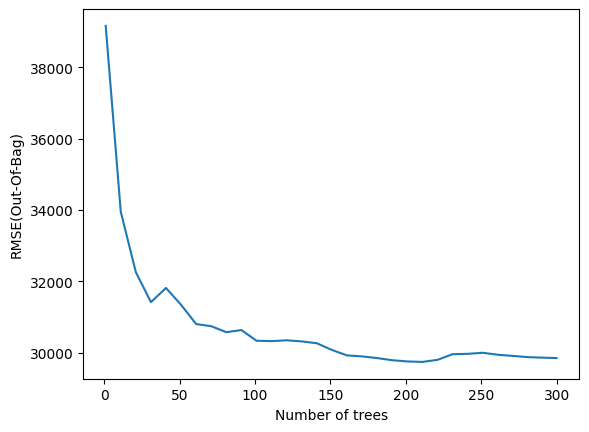

In [84]:
# training logs show the (RMSE) evaluated in the OOB data set

# Plot
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE(Out-Of-Bag)")
plt.show()

Smaller values are better for this hyperparam.

In [85]:
# stats on OOB data
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1015, accuracy=None, loss=None, rmse=29852.02708680498, ndcg=None, aucs=None, auuc=None, qini=None)

In [86]:
# evaluation on validation dataset
evaluation = rf.evaluate(x=valid_ds, return_dict=True)

for name, value in evaluation.items():
  print(f'{name}: {value:.4f}')

1/1 [==============================] - 1s 545ms/step - loss: 0.0000e+00 - mse: 678329920.0000
loss: 0.0000
mse: 678329920.0000


***Variable Importances***

Variable importances generally indicate how much a feature contributes to the model predictions or quality.

In [87]:
#  list the available Variable Importances for Decision Trees:
print(f'Available variable importances: ')
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances: 
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


As an example, let us display the important features for the Variable Importance NUM_AS_ROOT.

The larger the importance score for NUM_AS_ROOT, the more impact it has on the outcome of the model.

In [88]:
'''
The larger the importance score for NUM_AS_ROOT,
the more impact it has on the outcome of the model.
'''
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 120.0),
 ("ExterQual" (4; #22), 52.0),
 ("Neighborhood" (4; #59), 38.0),
 ("GarageCars" (1; #32), 27.0),
 ("GrLivArea" (1; #38), 20.0),
 ("BsmtQual" (4; #14), 9.0),
 ("KitchenQual" (4; #44), 8.0),
 ("TotalBsmtSF" (1; #73), 7.0),
 ("YearBuilt" (1; #76), 7.0),
 ("1stFlrSF" (1; #0), 5.0),
 ("GarageArea" (1; #31), 4.0),
 ("GarageYrBlt" (1; #37), 3.0)]

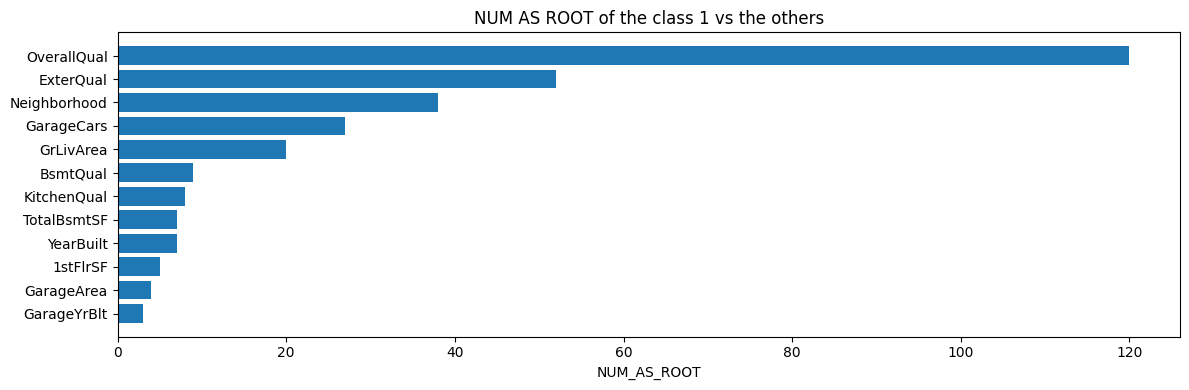

In [89]:
'''
Plot the variable importances from the inspector using Matplotlib
'''
plt.figure(figsize=(12,4))

# Mean decrease in AUC of class 1 vs. others
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract feture name and importance value
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]

# Features orderes in decreasing importance variable
feature_ranks = range(len(feature_names))

bar = plt.barh(
    feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# Label each par with values
'''
Ignoring the TypeError while moving forward to plotting the data
'''
try:
  for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(),
           patch.get_y(), f"{importance:.4f}", va='top')
except Exception:
    pass

# plot
plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [90]:
test_data = pd.read_csv('test.csv')
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data, task=tfdf.keras.Task.REGRESSION)
preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 29ms/step


,Id,SalePrice
0,1461,124153.234375
1,1462,154813.312500
2,1463,179039.078125
3,1464,181456.171875
4,1465,196426.718750


***CatBoost Method:***

In [91]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [92]:
# Replacing:

# The values of the "MSZoning" column with 1 for RH, 2 for RL, 3 for RM,
# 4 for FV and 5 for C (all).
test_df['MSZoning'] = test_df['MSZoning'].replace({'RH':1, 'RL':2, 'RM':3,
                                                   'FV':4, 'C (all)':5})
train_df['MSZoning'] = train_df['MSZoning'].replace({'RH':1, 'RL':2, 'RM':3,
                                                   'FV':4, 'C (all)':5})

# The values of the "Street" column with 1 for Pave and 2 for Grvl.
test_df['Street'] = test_df['Street'].replace({'Pave':1, 'GRvl':2})
train_df['Street'] = train_df['Street'].replace({'Pave':1, 'GRvl':2})

# The values of the "Alley" column with 1 for Pave and 2 for Grvl.
test_df['Alley'] = test_df['Alley'].replace({'Pave':1, 'Grvl':2})
train_df['Alley'] = train_df['Alley'].replace({'Pave':1, 'Grvl':2})

# The values of the "LotShape" column with 0 for Reg,
# 1 for IR1, 2 for IR2 and 3 for IR3.
test_df['LotShape'] = test_df['LotShape'].replace({'Reg':0, 'IR1':1,
                                                   'IR2':2, 'IR3':3})
train_df['LotShape'] = train_df['LotShape'].replace({'Reg':0, 'IR1':1,
                                                   'IR2':2, 'IR3':3})
# The values of the "LandContour" column with 0 for Lvl,
# 1 for HLS, 2 for Bnk and 3 for Low.
test_df['LandContour'] = test_df['LandContour'].replace({'Lv1':0, 'HLS':1,
                                                         'Bnk':2,'Low':3})
train_df['LandContour'] = train_df['LandContour'].replace({'Lv1':0, 'HLS':1,
                                                         'Bnk':2,'Low':3})
# The values of the "Utilities" column with 1 for AllPub and 2 for NoSeWa.
test_df['Utilities'] = test_df['Utilities'].replace({'AllPub':1, 'NoSewa':2})
train_df['Utilities'] = train_df['Utilities'].replace({'AllPub':1, 'NoSewa':2})

# The values of the "LotConfig" column with 1 for Inside, 2 for FR2,
# 3 for FR3, 4 for Corner and 5 for CulDSac.
test_df['LotConfig'] = test_df['LotConfig'].replace({'Inside':1,'FR2':2,'FR3':3,
                                                     'Corner':4,'CulDSac':5})
train_df['LotConfig'] = train_df['LotConfig'].replace({'Inside':1,'FR2':2,'FR3':3,
                                                     'Corner':4,'CulDSac':5})
# The values of the "LandSlope" column with 1 for Gtl, 2 for Mod and 3 for Sev.
test_df['LandSlope'] = test_df['LandSlope'].replace({'Gtl':1,'Mod':2,'Sev':3})
train_df['LandSlope'] = train_df['LandSlope'].replace({'Gtl':1,'Mod':2,'Sev':3})

'''
The values of the "Neighborhood" column with 0 for NAmes, 1 for Gilbert,
2 for StoneBr, 3 for BrDale, 4 for NPkVill, 5 for NridgHt, 6 for Blmngtn,
7 for NoRidge, 8 for Somerst, 9 for SawyerW, 10 for Sawyer, 11 for NWAmes,
12 for OldTown, 13 for BrkSide, 14 for ClearCr, 15 for SWISU, 16 for Edwards,
17 for CollgCr, 18 for Crawfor, 19 for Blueste, 20 for IDOTRR, 21 for Mitchel,
22 for Timber, 23 for MeadowV and 24 for Veenker
'''
test_df['Neighborhood'] = test_df['Neighborhood'].replace({'NAmes':0,'Gilbert':1,
                                                           'StoneBr':2,'BrDale':3,
                                                           'NPkVill':4,'NridgHt':5,
                                                           'Blmngtn':6,'NoRidge':7,
                                                           'Somerst':8,'SawyerW':9,
                                                           'Sawyer':10,'NWAmes':11,
                                                           'OldTown':12,'BrkSide':13,
                                                           'ClearCr':14,'SWISU':15,
                                                           'Edwards':16,'CollgCr':17,
                                                           'Crawfor':18,'Blueste':19,
                                                           'IDOTRR':20,'Mitchel':21,
                                                           'Timber':22,'MeadowV':23,
                                                           'Veenkeer':24})
train_df['Neighborhood'] = train_df['Neighborhood'].replace({'NAmes':0,'Gilbert':1,
                                                           'StoneBr':2,'BrDale':3,
                                                           'NPkVill':4,'NridgHt':5,
                                                           'Blmngtn':6,'NoRidge':7,
                                                           'Somerst':8,'SawyerW':9,
                                                           'Sawyer':10,'NWAmes':11,
                                                           'OldTown':12,'BrkSide':13,
                                                           'ClearCr':14,'SWISU':15,
                                                           'Edwards':16,'CollgCr':17,
                                                           'Crawfor':18,'Blueste':19,
                                                           'IDOTRR':20,'Mitchel':21,
                                                           'Timber':22,'MeadowV':23,
                                                           'Veenkeer':24})
'''
The values of the "Condition1" column with 0 for Feedr, 1 for Norm, 2 for PosN,
3 for RRNe, 4 for Artery, 5 for RRNn, 6 for PosA, 7 for RRAn and 8 for RRAe.
'''
test_df['Condition1'] = test_df['Condition1'].replace({'Feedr':0,'Norm':1,
                                                       'PosN':2,'RRNe':3,
                                                       'Artery':4,'RRNn':5,
                                                       'PosA':6,'RRAn':7,
                                                       'RRAe':8})
train_df['Condition1'] = train_df['Condition1'].replace({'Feedr':0,'Norm':1,
                                                       'PosN':2,'RRNe':3,
                                                       'Artery':4,'RRNn':5,
                                                       'PosA':6,'RRAn':7,
                                                       'RRAe':8})
'''
The values of the "Condition2" column with 0 for Feedr, 1 for Norm, 2 for PosN,
3 for RRNe, 4 for Artery, 5 for RRNn, 6 for PosA, 7 for RRAn and 8 for RRAe.
'''
test_df['Condition2'] = test_df['Condition2'].replace({'Feedr':0,'Norm':1,
                                                       'PosN':2,'RRNe':3,
                                                       'Artery':4,'RRNe':5,
                                                       'PosA':6,'RRAn':7,
                                                       'RRAe':8})
train_df['Condition2'] = train_df['Condition2'].replace({'Feedr':0,'Norm':1,
                                                       'PosN':2,'RRNe':3,
                                                       'Artery':4,'RRNe':5,
                                                       'PosA':6,'RRAn':7,
                                                       'RRAe':8})

'''
The values of the "BldgType" column with 1 for 1Fam,
2 for 2fmCon, 3 for TwnhsE, 4 for Twnhs and 5 for Duplex.
'''
test_df['BldgType'] = test_df['BldgType'].replace({'1Fam':1,'2fmCon':2,
                                                   'TwnhsE':3,'Twnhs':4,
                                                   'Duplex':5})
train_df['BldgType'] = train_df['BldgType'].replace({'1Fam':1,'2fmCon':2,
                                                   'TwnhsE':3,'Twnhs':4,
                                                   'Duplex':5})

'''
The values of the "HouseStyle" column with 0 for 2.5Fin, 1 for 1Story,
2 for 2Story, 3 for SLvl, 4 for 1.5Fin, 5 for SFoyer, 6 for 2.5Unf
and 7 for 1.5Unf.
'''
test_df['HouseStyle'] = test_df['HouseStyle'].replace({'2.5Fin':0,'1Story':1,
                                                       '2Story':2,'Slv1':3,
                                                       '1.5Fin':4,'SFoyer':5,
                                                       '2.5Unf':6,'1.5Unf':7})

train_df['HouseStyle'] = train_df['HouseStyle'].replace({'2.5Fin':0,'1Story':1,
                                                       '2Story':2,'Slv1':3,
                                                       '1.5Fin':4,'SFoyer':5,
                                                       '2.5Unf':6,'1.5Unf':7})
'''
The values of the "RoofMatl" column with 0 for CompShg, 1 for Tar&Grv, 2 for
WdShake, 3 for WdShngl, 4 for Metal, 5 for Roll, 6 for ClyTile
and 7 for Membran.
'''
test_df['RoofMatl'] = test_df['RoofMatl'].replace({'CompShg':0,'Tar&Grv':1,
                                                       'WdShake':2,'WdShngl':3,
                                                       'Metal':4,'Roll':5,
                                                       'ClyTile':6,'Membran':7})
train_df['RoofMatl'] = train_df['RoofMatl'].replace({'CompShg':0,'Tar&Grv':1,
                                                       'WdShake':2,'WdShngl':3,
                                                       'Metal':4,'Roll':5,
                                                       'ClyTile':6,'Membran':7})
'''
The values of the "Exterior1st" column with 1 for VinylSd, 2 for Wd Sdng,
3 for HdBoard, 4 for Plywood, 5 for MetalSd, 6 for CemntBd, 7 for WdShing,
8 for BrkFace, 9 for AsbShng, 10 for BrkComm, 11 for Stucco, 12 for AsphShn,
13 for CBlock, 14 for Stone and 15 for ImStucc.
'''
test_df['Exterior1st'] = test_df['Exterior1st'].replace({'Viny1Sd':1,'Wd Sdng':2,
                                                         'HdBoard':3,'Plywood':4,
                                                         'MetalSd':5,'CemntBd':6,
                                                         'WdShing':7,'BrkFace':8,
                                                         'AsbShng':9,'BrkComm':10,
                                                         'Stucco':11,'AsphShn':12,
                                                         'CBlock':13,'Stone':14,
                                                         'Imstucc':15})
train_df['Exterior1st'] = train_df['Exterior1st'].replace({'Viny1Sd':1,'Wd Sdng':2,
                                                         'HdBoard':3,'Plywood':4,
                                                         'MetalSd':5,'CemntBd':6,
                                                         'WdShing':7,'BrkFace':8,
                                                         'AsbShng':9,'BrkComm':10,
                                                         'Stucco':11,'AsphShn':12,
                                                         'CBlock':13,'Stone':14,
                                                         'Imstucc':15})

'''
The values of the "Exterior2nd" column with 1 for VinylSd, 2 for Wd Sdng,
3 for HdBoard, 4 for Plywood, 5 for MetalSd, 6 for Brk Cmn,
7 for CmentBd, 8 for ImStucc, 9 for Wd Shng, 10 for AsbShng,
11 for Stucco, 12 for CBlock, 13 for BrkFace, 14 for AsphShn,
15 for Stone and 16 for Other.
'''
test_df['Exterior2nd'] = test_df['Exterior2nd'].replace({'Viny1Sd':1,'Wd Sdng':2,
                                                         'HdBoard':3,'Plywood':4,
                                                         'MetalSd':5,'Brk Cmn':6,
                                                         'CmentBd':7,'ImStucc':8,
                                                         'Wd Shng':9,'AsbShng':10,
                                                         'Stucco':11,'CBlock':12,
                                                         'BrkFace':13,'AsphShn':14,
                                                         'Stone':15,'Other':16})
train_df['Exterior2nd'] = train_df['Exterior2nd'].replace({'Viny1Sd':1,'Wd Sdng':2,
                                                         'HdBoard':3,'Plywood':4,
                                                         'MetalSd':5,'Brk Cmn':6,
                                                         'CmentBd':7,'ImStucc':8,
                                                         'Wd Shng':9,'AsbShng':10,
                                                         'Stucco':11,'CBlock':12,
                                                         'BrkFace':13,'AsphShn':14,
                                                         'Stone':15,'Other':16})

In [93]:
# Replacing:

'''
The values of the "MasVnrType" column with 1 for None,
2 for BrkFace, 3 for Stone and 4 for BrkCmn.
'''
test_df['MasVnrType'] = test_df['MasVnrType'].replace({'None':1,'BrkFace':2,
                                                       'Stone':3,'BrkCmn':4})
train_df['MasVnrType'] = train_df['MasVnrType'].replace({'None':1,'BrkFace':2,
                                                       'Stone':3,'BrkCmn':4})
'''
The values of the "ExterQual" column with 1 for TA, 2 for Gd,
3 for Ex and 4 for Fa.
'''
test_df['ExterQual'] = test_df['ExterQual'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4})
train_df['ExterQual'] = train_df['ExterQual'].replace({'TA':1,'Gd':2,
                                                       'Ex':3,'Fa':4})
'''
The values of the "ExterCond" column with 1 for TA, 2 for Gd, 3 for Ex,
4 for Fa and 5 for Po.
'''
test_df['ExterCond'] = test_df['ExterCond'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,
                                                     'Po':5})
train_df['ExterCond'] = train_df['ExterCond'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,
                                                     'Po':5})
'''
The values of the "Foundation" column with 1 for CBlock, 2 for PConc,
3 for BrkTil, 4 for Stone,5 for Slab and 6 for Wood.
'''
test_df['Foundation'] = test_df['Foundation'].replace({'CBlock':1,'PConc':2,
                                                     'BrkTil':3,'Stone':4,
                                                     'Slab':5,'Wood':6})
train_df['Foundation'] = train_df['Foundation'].replace({'CBlock':1,'PConc':2,
                                                     'BrkTil':3,'Stone':4,
                                                     'Slab':5,'Wood':6})
'''
The values of the "BsmtQual" column with 1 for TA, 2 for Gd,
3 for Ex and 4 for Fa.
'''
test_df['BsmtQual'] = test_df['BsmtQual'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,})
train_df['BsmtQual'] = train_df['BsmtQual'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,})
'''
The values of the "BsmtCond" column with 1 for TA, 2 for Gd,
3 for Po and 4 for Fa.
'''
test_df['BsmtCond'] = test_df['BsmtCond'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,})
train_df['BsmtCond'] = train_df['BsmtCond'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,})
'''
The values of the "BsmtExposure" column with 1 for No, 2 for Gd,
3 for Mn and 4 for Av.
'''
test_df['BsmtExposure'] = test_df['BsmtExposure'].replace({'No':1,'Gd':2,
                                                     'Mn':3,'Av':4,})
train_df['BsmtExposure'] = train_df['BsmtExposure'].replace({'No':1,'Gd':2,
                                                     'Mn':3,'Av':4,})
'''
The values of the "BsmtFinType1" column with 1 for Rec,
2 for ALQ, 3 for GLQ, 4 for Unf,5 for BLQ and 6 for LwQ.
'''
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].replace({'Rec':1,'ALQ':2,
                                                           'GLQ':3,'Unf':4,
                                                           'BLQ':5,'LwQ':6})
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].replace({'Rec':1,'ALQ':2,
                                                           'GLQ':3,'Unf':4,
                                                           'BLQ':5,'LwQ':6})
'''
The values of the "BsmtFinType2" column with 1 for Rec,
2 for ALQ, 3 for GLQ, 4 for Unf,5 for BLQ and 6 for LwQ.
'''
test_df['BsmtFinType2'] = test_df['BsmtFinType2'].replace({'Rec':1,'ALQ':2,
                                                           'GLQ':3,'Unf':4,
                                                           'BLQ':5,'LwQ':6})
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].replace({'Rec':1,'ALQ':2,
                                                           'GLQ':3,'Unf':4,
                                                           'BLQ':5,'LwQ':6})
'''
The values of the "Heating" column with 1 for GasA,
2 for GasW, 3 for Grav, 4 for Wall,5 for OthW and 6 for Floor.
'''
test_df['Heating'] = test_df['Heating'].replace({'GasA':1,'GasW':2,
                                                 'Grav':3,'Wall':4,
                                                 'OthW':5,'Floor':6})
train_df['Heating'] = train_df['Heating'].replace({'GasA':1,'GasW':2,
                                                 'Grav':3,'Wall':4,
                                                 'OthW':5,'Floor':6})
'''
The values of the "HeatingQC" column with 1 for TA,
2 for Gd, 3 for Ex, 4 for Fa and 5 for Po.
'''
test_df['HeatingQC'] = test_df['HeatingQC'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,
                                                     'Po':5})
train_df['HeatingQC'] = train_df['HeatingQC'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4,
                                                     'Po':5})
'''
The values of the "CentralAir" column with 1 for Y and 2 for N.
'''
test_df['CentralAir'] = test_df['CentralAir'].replace({'Y':1,'N':2})
train_df['CentralAir'] = train_df['CentralAir'].replace({'Y':1,'N':2})

'''
The values of the "Electrical" column with 1 for SBrkr, 2 for FuseF,
3 for FuseA, 4 for FuseP and 5 for Mix.
'''
test_df['Electrical'] = test_df['Electrical'].replace({'SBrkr':1,'FuseF':2,
                                                     'FuseA':3,'FuseP':4,
                                                     'Mix':5})
train_df['Electrical'] = train_df['Electrical'].replace({'SBrkr':1,'FuseF':2,
                                                     'FuseA':3,'FuseP':4,
                                                     'Mix':5})
'''
The values of the "KitchenQual" column with 1 for TA, 2 for Gd,
3 for Ex and 4 for Fa.
'''
test_df['KitchenQual'] = test_df['KitchenQual'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4})
train_df['KitchenQual'] = train_df['KitchenQual'].replace({'TA':1,'Gd':2,
                                                     'Ex':3,'Fa':4})
'''
The values of the "Functional" column with 1 for Typ, 2 for Min2, 3 for Min1,
4 for Mod,5 for Maj1, 6 for Sev and 7 for Maj2.
'''
test_df['Functional'] = test_df['Functional'].replace({'Typ':1,'Min2':2,
                                                       'Min1':3,'Mod':4,
                                                       'Maj1':5,'Sev':6,
                                                       'Maj2':7})
train_df['Functional'] = train_df['Functional'].replace({'Typ':1,'Min2':2,
                                                       'Min1':3,'Mod':4,
                                                       'Maj1':5,'Sev':6,
                                                       'Maj2':7})
'''
The values of the "FireplaceQu" column with 1 for TA, 2 for Gd,
3 for Ex, 4 for Fa and 5 for Po.
'''
test_df['FireplaceQu'] = test_df['FireplaceQu'].replace({'TA':1,'Gd':2,
                                                       'Ex':3,'Fa':4,
                                                       'Po':5})
train_df['FireplaceQu'] = train_df['FireplaceQu'].replace({'TA':1,'Gd':2,
                                                       'Ex':3,'Fa':4,
                                                       'Po':5})
'''
The values of the "GarageType" column with 1 for Attchd, 2 for Detchd,
3 for BuiltIn, 4 for Basment,5 for 2Types and 6 for CarPort.
'''
test_df['GarageType'] = test_df['GarageType'].replace({'Attchd':1,'Detchd':2,
                                                       'BuiltIn':3,'Basment':4,
                                                       '2Types':5,'Carport':6})
train_df['GarageType'] = train_df['GarageType'].replace({'Attchd':1,'Detchd':2,
                                                       'BuiltIn':3,'Basment':4,
                                                       '2Types':5,'Carport':6})
'''
The values of the "GarageFinish" column with 1 for Unf, 2 for Fin and 3 for RFn.
'''
test_df['GarageFinish'] = test_df['GarageFinish'].replace({'Unf':1,'Fin':2,
                                                       'RFn':3})
train_df['GarageFinish'] = train_df['GarageFinish'].replace({'Unf':1,'Fin':2,
                                                       'RFn':3})
'''
The values of the "GarageQual" column with 1 for TA, 2 for Gd,
3 for Po and 4 for Fa.
'''
test_df['GarageQual'] = test_df['GarageQual'].replace({'TA':1,'Gd':2,
                                                       'Po':3,'Fa':4})
train_df['GarageQual'] = train_df['GarageQual'].replace({'TA':1,'Gd':2,
                                                       'Po':3,'Fa':4})
'''
The values of the "GarageCond" column with 1 for TA, 2 for Gd, 3 for Ex,
4 for Fa and 5 for Po.
'''
test_df['GarageCond'] = test_df['GarageCond'].replace({'TA':1,'Gd':2,
                                                       'Ex':3,'Fa':4,
                                                       'Po':5})
train_df['GarageCond'] = train_df['GarageCond'].replace({'TA':1,'Gd':2,
                                                       'Ex':3,'Fa':4,
                                                       'Po':5})
'''
The values of the "PavedDrive" column with 1 for Y, 2 for N and 3 for P.
'''
test_df['PavedDrive'] = test_df['PavedDrive'].replace({'Y':1,'N':2,
                                                       'P':3})
train_df['PavedDrive'] = train_df['PavedDrive'].replace({'Y':1,'N':2,
                                                       'P':3})
'''
The values of the "PoolQC" column with 1 for Ex, 2 for Gd and 3 for Fa.
'''
test_df['PoolQC'] = test_df['PoolQC'].replace({'Ex':1,'Gd':2,
                                               'Fa':3})
train_df['PoolQC'] = train_df['PoolQC'].replace({'Ex':1,'Gd':2,
                                               'Fa':3})
'''
The values of the "Fence" column with 1 for MnPrv, 2 for GdPrv,
3 for GdWo and 4 for MnWw.
'''
test_df['Fence'] = test_df['Fence'].replace({'MnPrv':1,'GdPrv':2,
                                               'GdWo':3,'MnWw':4})
train_df['Fence'] = train_df['Fence'].replace({'MnPrv':1,'GdPrv':2,
                                               'GdWo':3,'MnWw':4})
'''
The values of the "MiscFeature" column with 1 for Gar2, 2 for Shed, 3 for Othr and 4 for TenC.
'''
test_df['MiscFeature'] = test_df['MiscFeature'].replace({'Gar2':1,'Shed':2,
                                                         'Othr':3,'TenC':4})
train_df['MiscFeature'] = train_df['MiscFeature'].replace({'Gar2':1,'Shed':2,
                                                         'Othr':3,'TenC':4})
'''
The values of the "SaleType" column with 1 for WD, 2 for COD, 3 for New,
4 for ConLD, 5 for Oth, 6 for Con, 7 for ConLw, 8 for ConLI and 9 for CWD.
'''
test_df['SaleType'] = test_df['SaleType'].replace({'WD':1,'COD':2,
                                                   'New':3,'ConLD':4,
                                                   'Oth':5,'Con':6,
                                                   'ConLw':7,'ConLI':8,
                                                   'CWD':9})
train_df['SaleType'] = train_df['SaleType'].replace({'WD':1,'COD':2,
                                                   'New':3,'ConLD':4,
                                                   'Oth':5,'Con':6,
                                                   'ConLw':7,'ConLI':8,
                                                   'CWD':9})
'''
The values of the "SaleCondition" column with 1 for Normal, 2 for Partial, 3 for Abnorml, 4 for Family,5 for Alloca and 6 for AdjLand.
'''
test_df['SaleCondition'] = test_df['SaleCondition'].replace({'Normal':1,'Partial':2,
                                                   'Abnormal':3,'Family':4,
                                                   'Alloca':5,'AdjLand':6})
train_df['SaleCondition'] = train_df['SaleCondition'].replace({'Normal':1,'Partial':2,
                                                   'Abnormal':3,'Family':4,
                                                   'Alloca':5,'AdjLand':6})
'''
The values of the "RoofStyle" column with 1 for Gable, 2 for Hip, 3 for Gambrel, 4 for Flat,5 for Mansard and 6 for Shed.
'''
test_df['RoofStyle'] = test_df['RoofStyle'].replace({'Gabel':1,'Hip':2,
                                                   'Gambrel':3,'Flat':4,
                                                   'Mansard':5,'Shed':6})
train_df['RoofStyle'] = train_df['RoofStyle'].replace({'Gabel':1,'Hip':2,
                                                   'Gambrel':3,'Flat':4,
                                                   'Mansard':5,'Shed':6})

In [94]:
# Filling in the missing values:
test_df['MSZoning'] = test_df['MSZoning'].fillna(
    test_df.groupby('MSSubClass')['MSZoning'].transform(
        lambda x: x.mode().iloc[0]))


test_df['LotFrontage'] = test_df['LotFrontage'].fillna(
    test_df.groupby('Neighborhood')['LotFrontage'].transform('median'))
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(
    train_df.groupby('Neighborhood')['LotFrontage'].transform('median'))

test_df['Alley'] = test_df['Alley'].fillna(0)
train_df['Alley'] = train_df['Alley'].fillna(0)

test_df['Utilities'] = test_df['Utilities'].fillna(0)

test_df['Exterior1st'] = test_df['Exterior1st'].fillna(
    test_df['Exterior1st'].mode()[0])

test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(
    test_df['Exterior2nd'].mode()[0])

test_df['MasVnrType'] = test_df['MasVnrType'].fillna(0)
train_df['MasVnrType'] = train_df['MasVnrType'].fillna(0)

test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(
    test_df['MasVnrArea'].mean())
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(
    train_df['MasVnrArea'].mean())

test_df['BsmtQual'] = test_df['BsmtQual'].fillna(0)
train_df['BsmtQual'] = train_df['BsmtQual'].fillna(0)

test_df['BsmtCond'] = test_df['BsmtCond'].fillna(0)
train_df['BsmtCond'] = train_df['BsmtCond'].fillna(0)

test_df['BsmtExposure'] = test_df['BsmtExposure'].fillna(0)
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna(0)

test_df['BsmtFinType1'] = test_df['BsmtFinType1'].fillna(0)
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna(0)

test_df['BsmtFinSF1'] = test_df['BsmtFinSF1'].fillna(
    test_df['BsmtFinSF1'].mean())

test_df['BsmtFinType2'] = test_df['BsmtFinType2'].fillna(0)
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna(0)

test_df['BsmtFinSF2'] = test_df['BsmtFinSF2'].fillna(
    test_df['BsmtFinSF2'].mean())

test_df['BsmtUnfSF'] = test_df['BsmtUnfSF'].fillna(test_df['BsmtUnfSF'].mean())

test_df['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(
    test_df['TotalBsmtSF'].mean())

test_df['BsmtFullBath'] = test_df['BsmtFullBath'].fillna(4)

test_df['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(3)

test_df['KitchenQual'] = test_df['KitchenQual'].fillna(0)

test_df['Functional'] = test_df['Functional'].fillna(0)

test_df['FireplaceQu'] = test_df['FireplaceQu'].fillna(0)
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna(0)

test_df['GarageType'] = test_df['GarageType'].fillna(0)
train_df['GarageType'] = train_df['GarageType'].fillna(0)

test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(test_df['YearBuilt'])
test_df.loc[test_df['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['YearBuilt'])

test_df['GarageFinish'] = test_df['GarageFinish'].fillna(0)
train_df['GarageFinish'] = train_df['GarageFinish'].fillna(0)

test_df['GarageCars'] = test_df['GarageCars'].fillna(6)

test_df['GarageArea'] = test_df['GarageArea'].fillna(0)

test_df['GarageQual'] = test_df['GarageQual'].fillna(0)
train_df['GarageQual'] = train_df['GarageQual'].fillna(0)

test_df['GarageCond'] = test_df['GarageCond'].fillna(0)
train_df['GarageCond'] = train_df['GarageCond'].fillna(0)

test_df['PoolQC'] = test_df['PoolQC'].fillna(0)
train_df['PoolQC'] = train_df['PoolQC'].fillna(0)

test_df['Fence'] = test_df['Fence'].fillna(0)
train_df['Fence'] = train_df['Fence'].fillna(0)

test_df['MiscFeature'] = test_df['MiscFeature'].fillna(0)
train_df['MiscFeature'] = train_df['MiscFeature'].fillna(0)

test_df['SaleType'] = test_df['SaleType'].fillna(test_df['SaleType'].mode()[0])

train_df['Electrical'] = train_df['Electrical'].fillna(0)

In [95]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   float64
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   float64
 7   LotShape       1459 non-null   int64  
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   float64
 10  LotConfig      1459 non-null   int64  
 11  LandSlope      1459 non-null   int64  
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   int64  
 14  Condition2     1459 non-null   int64  
 15  BldgType       1459 non-null   int64  
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

**CatBoost Method**

In [96]:
defining_column = ['SalePrice']

In [97]:
X_train_df = train_df.iloc[:,:-1]
y_train_df = train_df[defining_column]

In [98]:
# get all object variables from X_train
'''
 If the dataframe was read in oddly, (pd.read_csv) and converted some dtype
 that's normally float or int it will still process.
'''
cat_vars = [var for var in X_train_df.columns if X_train_df[var].dtype == "O"]

# calling our catboost method under 'preliminary_model' variable
preliminary_model = CatBoostRegressor(cat_features=cat_vars, depth = 7,
                                      iterations = 70, l2_leaf_reg = 5,
                                      learning_rate = 0.1)
# train the model
preliminary_model.fit(X_train_df, y_train_df)

0:	learn: 74615.4174389	total: 12.7ms	remaining: 874ms
1:	learn: 70188.3405742	total: 25.8ms	remaining: 876ms
2:	learn: 66205.5799806	total: 37.5ms	remaining: 838ms
3:	learn: 62777.7475913	total: 51.4ms	remaining: 847ms
4:	learn: 59370.6549408	total: 77.8ms	remaining: 1.01s
5:	learn: 56183.8109945	total: 108ms	remaining: 1.15s
6:	learn: 53370.6535771	total: 135ms	remaining: 1.22s
7:	learn: 50760.8769561	total: 161ms	remaining: 1.24s
8:	learn: 48680.7557846	total: 188ms	remaining: 1.27s
9:	learn: 46611.7300643	total: 215ms	remaining: 1.29s
10:	learn: 44857.8155576	total: 235ms	remaining: 1.26s
11:	learn: 42897.6190252	total: 260ms	remaining: 1.25s
12:	learn: 41392.4470967	total: 284ms	remaining: 1.25s
13:	learn: 39938.6469279	total: 310ms	remaining: 1.24s
14:	learn: 38691.0502054	total: 351ms	remaining: 1.29s
15:	learn: 37331.4965124	total: 382ms	remaining: 1.29s
16:	learn: 36141.3186661	total: 421ms	remaining: 1.31s
17:	learn: 35070.2103187	total: 448ms	remaining: 1.29s
18:	learn: 3423

**Predict:**

In [99]:
preliminary_model.predict(X_train_df)

array([201953.13064394, 166557.65133466, 213513.36091374, ...,
       234201.63077422, 126370.63211811, 148532.10998184])

In [100]:
score = preliminary_model.score(X_train_df,y_train_df)
print(f'Estimation of determination accuracy: {score*100:.2f}%')

Estimation of determination accuracy: 94.00%


In [101]:
# predict the results on the test dataset
# X_test_df = test_df

#pre_test_df = preliminary_model.predict(X_test_df)
#pre_test_df

In [102]:
#test_df['SalePrice'] = pre_test_df
#test_df.head()

**Saving to csv file:**

In [103]:
# SalePrice = test_df['SalePrice'].to_csv('ML Project use Prices_CAT.csv')